In [2]:
import torch
import torchvision
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot
import torchvision.transforms as T
from evidentialdl.layers import DenseDirichlet
import numpy as np
from evidentialdl.losses import dirichlet_loss

In [3]:
n_epochs = 4
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                               transform=mnist_transforms),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                               transform=mnist_transforms),
    batch_size=batch_size_test, shuffle=True)

43.6%

100.0%


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw


100.0%
100.0%


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



100.0%



Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = DenseDirichlet(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        return self.fc2(x)


network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]
K = 10
criterion = dirichlet_loss(K)

def train(epoch):
    network.train()
    global_step = 0
    n_batches = len(train_loader)
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        target = torch.from_numpy(to_categorical(target, num_classes=K))
        yhat = network(data)
        loss = criterion(target, yhat, global_step, K * n_batches)
        loss.backward()
        optimizer.step()
        global_step += 1
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            # torch.save(network.state_dict(), './results/model.pth')
            # torch.save(optimizer.state_dict(), './results/optimizer.pth')


def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            alpha, preds, eps_un, alea_un = network(data)
            test_loss += F.nll_loss(preds, target, size_average=False).item()
            pred = preds.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: -0.0993, Accuracy: 1137/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.944348
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.944590
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.949148
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.948715
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.947362
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.949181
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.954303
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.950531
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.953282
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.955510
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.961134
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.956393
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.957132
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.962937
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.961821
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.961048
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.962488
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.955781
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.960567
Train Epoch: 1 [1216

In [10]:
mnist_data = torchvision.datasets.MNIST('.', download=True)
rotater = T.RandomRotation(degrees=(90, 90))
real_image = mnist_data[0][0]
rotated_image = rotater(mnist_data[0][0])

# pyplot.imshow(rotated_image, cmap="gray")
# pyplot.show()

with torch.no_grad():
    alpha1, preds1, eps_un1, alea_un1 = network(torch.unsqueeze(mnist_transforms(rotated_image), 0))
    alpha, preds, eps_un, alea_un = network(torch.unsqueeze(mnist_transforms(real_image), 0))

36.7%

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100.0%
100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [11]:
d_alpha1 = np.random.dirichlet(torch.squeeze(alpha1), 20)
d_alpha = np.random.dirichlet(torch.squeeze(alpha), 20)

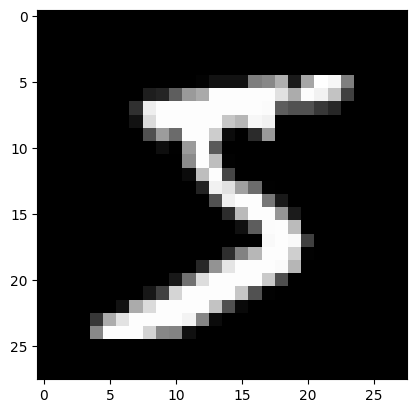

In [12]:
pyplot.imshow(real_image, cmap="gray")
pyplot.show()